In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import sys
sys.path.append('../src')
import monte_carlo as mc
import black_scholes as bs
import binomial_tree as bt
import payoff as po
from scipy.optimize import root_scalar

import pandas as pd
import yfinance as yf
import datetime as dt

# Volatility estimation

Volatility is central to risk management and option pricing, and in practice it is **time-varying**. This notebook estimates realized volatility using three approaches:

- **Yearly blocks** - calendar-year **standard deviation** of daily log-returns (annualized).
- **Sliding windows** - **rolling** annualized standard deviation with 21/63/252-day windows.
- **EWMA** - **exponentially weighted** variance with half-life $H$ (decay $\lambda = 2^{-1/H}$).

We illustrate results on **SPY**, **AAPL**, **JPM**, and **XOM** using **adjusted close** prices (split/dividend adjusted where applicable).

### Yearly blocks (coarse-grained view)

**Definition.** Compute daily **log-returns** $r_t = ln(P_t / P_{t-1})$; within each calendar year, take $\sigma_{\text{year}} = \sqrt{252} \cdot \sigma(r_t)$.

**Interpretation.** A **regime-level** picture: short-lived shocks are smoothed; longer trends stand out (e.g., 2008–09 GFC, 2020 COVID).


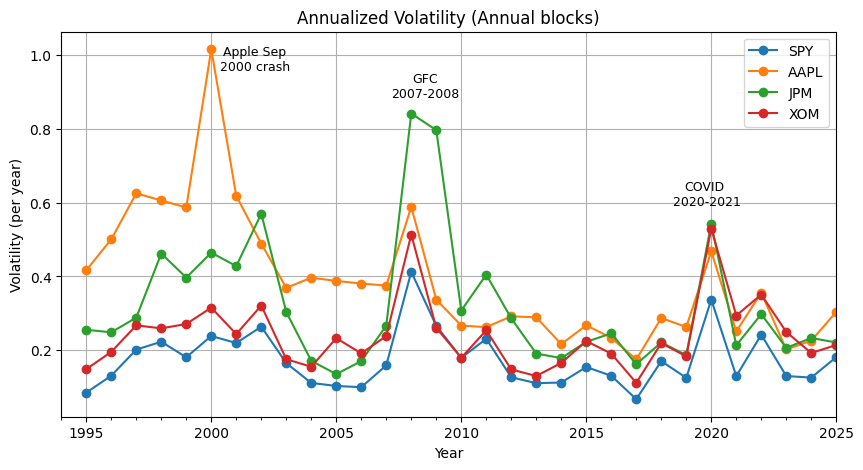

In [11]:
tickers = ["SPY","AAPL","JPM","XOM"]         
start   = "1995-01-01"                
end     = None  

raw = yf.download(tickers, start=start, end=end, interval="1d",auto_adjust=True, progress=False, group_by='ticker')

close = pd.concat({t: raw[t]["Close"] for t in tickers}, axis=1)
close = close.dropna(how="all")
rets = np.log(close).diff().dropna()

annual_vol = rets.groupby(rets.index.year).apply(lambda x: x.std() * np.sqrt(len(x)))
annual_vol.index = pd.to_datetime(annual_vol.index.astype(str))

ax = annual_vol.plot(figsize=(10,5), marker='o', title="Annualized Volatility (Annual blocks)")
ax.set_ylabel("Volatility (per year)")
ax.set_xlabel("Year")
ax = plt.gca()
ax.text(0.25, 0.9, "Apple Sep\n2000 crash", transform=ax.transAxes,fontsize=9, color="black",ha="center")
ax.text(0.47, 0.83, "GFC\n2007-2008", transform=ax.transAxes,fontsize=9, color="black",ha="center")
ax.text(0.83, 0.55, "COVID\n 2020-2021", transform=ax.transAxes,fontsize=9, color="black",ha="center")
plt.xlim("1994","2025") 
plt.grid(True)
plt.show()

### Sliding windows and EWMA

**Sliding windows.** For each date `t`, use **only data up to** `t` (no look-ahead). Windows: `21`, `63`, `252` trading days.  
• Short windows are **responsive but noisy**; long windows are **smoother but lag** turning points.

**EWMA.** Recursive variance  
$\sigma_t^2 = (1 - \lambda) * r_t^2 + \lambda * \sigma_{t-1}^2$, with $\lambda = 2^{-1/H}$.  
• Half-lives used: $H \in \{11.5,21, 63\}$.\
• Compared to simple rolling windows, EWMA **reduces blocky behavior** while staying reactive to recent data.

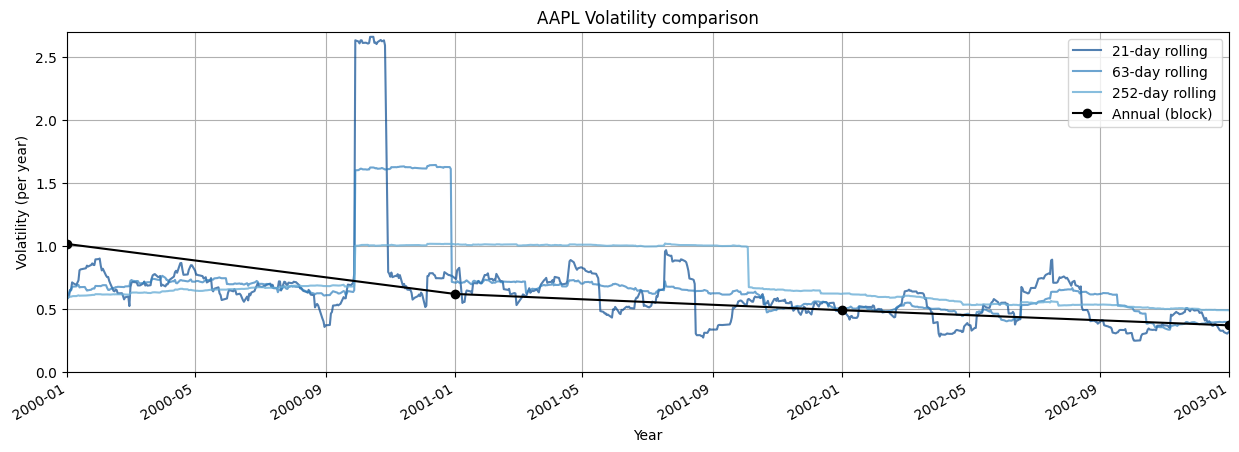

In [14]:
rolling_vol_21d = rets.rolling(window=21).std() * np.sqrt(252)
rolling_vol_63d = rets.rolling(window=63).std() * np.sqrt(252)
rolling_vol_252d = rets.rolling(window=252).std() * np.sqrt(252)

colors = [plt.cm.Blues(0.9),  plt.cm.Blues(0.7),plt.cm.Blues(0.5)]
fig, ax = plt.subplots(figsize=(15,5))


rolling_vol_21d["AAPL"].plot(ax=ax ,alpha=0.7,color=colors[0], label="21-day rolling")

rolling_vol_63d["AAPL"].plot(ax=ax, alpha=0.7, color=colors[1],label="63-day rolling")

rolling_vol_252d["AAPL"].plot(ax=ax, alpha=0.8,color=colors[2], label="252-day rolling")

annual_vol["AAPL"].plot(ax=ax, marker="o", color='black',label="Annual (block)")
plt.ylim(0,2.7) 
plt.xlim("2000","2003") 
ax.set_title("AAPL Volatility comparison")
ax.set_ylabel("Volatility (per year)")
ax.set_xlabel("Year")
ax.legend()
ax.grid(True)
plt.show()

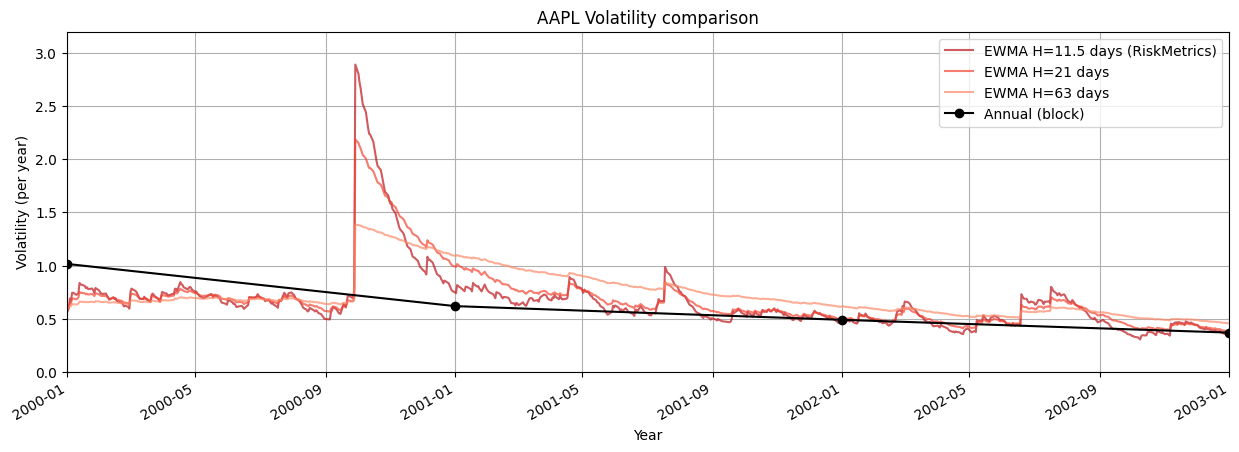

In [12]:

ewm_vol_21 = rets.ewm(halflife=21, adjust=False).std() * np.sqrt(252)
ewm_vol_63 = rets.ewm(halflife=63, adjust=False).std() * np.sqrt(252)
lam = 0.94
alpha = 1 - lam
ewm_vol_094 = rets.ewm(alpha=alpha, adjust=False).std() * np.sqrt(252)

colors = [plt.cm.Blues(0.8),  plt.cm.Blues(0.6),plt.cm.Blues(0.4)]
colors2 = [plt.cm.Reds(0.8),  plt.cm.Reds(0.6),plt.cm.Reds(0.4)]
fig, ax = plt.subplots(figsize=(15,5))


ewm_vol_094["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[0], label="EWMA H=11.5 days (RiskMetrics)")
ewm_vol_21["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[1], label="EWMA H=21 days")
ewm_vol_63["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[2], label="EWMA H=63 days")


annual_vol["AAPL"].plot(ax=ax, marker="o", color='black',label="Annual (block)")
plt.ylim(0,3.2) 
plt.xlim("2000","2003") 
ax.set_title("AAPL Volatility comparison")
ax.set_ylabel("Volatility (per year)")
ax.set_xlabel("Year")
ax.legend()
ax.grid(True)
plt.show()

### Putting all estimates together

Overlaying yearly blocks, rolling windows, and EWMA highlights the **bias–variance trade-off**:

- **Reactiveness:** 21-day rolling / small-`H` EWMA track shocks quickly.
- **Stability:** 252-day rolling / large-`H` EWMA and yearly blocks provide context and guard against noise.


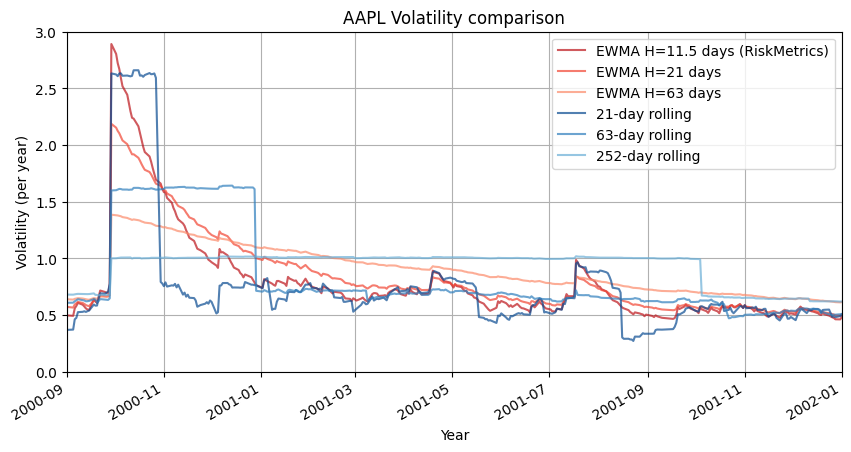

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ewm_vol_094["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[0], label="EWMA H=11.5 days (RiskMetrics)")

ewm_vol_21["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[1], label="EWMA H=21 days")

ewm_vol_63["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[2], label="EWMA H=63 days")

rolling_vol_21d["AAPL"].plot(ax=ax ,alpha=0.7,color=colors[0], label="21-day rolling")

rolling_vol_63d["AAPL"].plot(ax=ax, alpha=0.7, color=colors[1],label="63-day rolling")

rolling_vol_252d["AAPL"].plot(ax=ax, alpha=0.7,color=colors[2], label="252-day rolling")


# annual_vol["AAPL"].plot(ax=ax, marker="o", alpha=0.2,color='black',label="Annual (block)")
plt.ylim(0,3) 
plt.xlim("09-2000","2002") 
ax.set_title("AAPL Volatility comparison")
ax.set_ylabel("Volatility (per year)")
ax.set_xlabel("Year")
ax.legend()
ax.grid(True)
plt.show()

## Summary

**Goal.** Estimate and compare equity volatility using three realized-volatility estimators: yearly blocks, sliding windows, and EWMA.

**Data.** Daily **adjusted close** prices for SPY, AAPL, JPM, and XOM; period as loaded in the notebook.

**Methods.**
- **Yearly blocks:** annualized standard deviation of daily log-returns within each calendar year.  
- **Sliding windows:** rolling annualized standard deviation over 21, 63, and 252 trading days.  
- **EWMA:** $\sigma_t^2 = (1 - \lambda) * r_t^2 + \lambda \sigma_{t-1}^2$, with $\lambda = 2^{-1/H}$; half-lives $H \in \{21, 63, 252\}$.

**Key takeaways.**
- Short windows / small `H` **track high-frequency swings** but are noisier; long windows / large `H` **smooth drawdowns** and **lag** turning points.  
- EWMA acts as a **smoothed rolling estimator**: less blocky than simple moving windows while remaining reactive to recent shocks.